In [121]:
import numpy as np
import scipy as sc 
import pandas as pd 
from scipy.integrate import quad
from scipy.spatial.distance import squareform
from numpy import random
import networkx as nx
import pickle

from tv.data_load import load_data
import os
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
%matplotlib inline

path = '/cobrain/groups/ml_group/data/HCP/HCP/'
connec , thinkness, log_jac, unique_labels, labels, mean_area_eq, idx_subj_connec, idx_subj_think, idx_subj_logjac = load_data(path)


Connectomes:  (789, 2, 68, 68)
Thinkness:  (789, 2, 163842)
Log Jacob:  (789, 2, 163842)
Unique Labels:  (789, 2, 163842)
Mean Labels:  (2, 163842)
Mean Area eq:  (2, 163842)


In [122]:
class SpectraModel:
    def __init__(self, theta = 0.5, gamma = 0.1, prob_mode = 'uniform', tol = 1e-3):
        self.theta = theta 
        self.gamma = gamma
        self.tol = tol
        if prob_mode =='uniform':
            self.prob_mode = getattr(random, 'randint')
    def density_intergant(self, x, spectra):
        return self.gamma * np.sum([1/((x - w)**2 + self.gamma**2) for w in spectra])
        
    def density(self, G):
        T = G - np.diag(G.sum(axis = 0))
        spectra = sc.linalg.eigvals(T)
        integ = quad(self.density_intergant, 0 , np.inf, args=spectra)
        C = 1./integ[0]
        return spectra, C
    def dist_integrant(self, x, spectra1, C1, spectra2, C2):
        return (C1 * self.density_intergant(x, spectra1) - C2 * self.density_intergant(x, spectra2))**2
    
    def dist(self, spectra1, C1, spectra2, C2):
        return np.sqrt(quad(self.dist_integrant, 0, np.inf, args=(spectra1, C1, spectra2, C2))[0])
    
    def mutation(self, G):
        nodes = np.arange(self.n)
        np.random.shuffle(nodes)
        i = nodes[0]
        
        mi = self.prob_mode(0, self.n)
        new_G = G.copy()
        new_G[i, :] = 0
        new_G[:, i] = 0
        np.random.shuffle(nodes)
        new_edges = nodes[:mi]
        
        new_G[i, new_edges] = 1
        new_G[new_edges, i] = 1
        
        return new_G
        
        
    def generate(self, adj, start_model = 'erdos_renyi_graph',):
        
        assert len(adj.shape) == 2, 'Graph should be a two dim matrix'
        assert adj.shape[0] == adj.shape[0], 'Not square matrix for Graph'
        
        self.n = adj.shape[0]
        self.G0 = adj
        
        G = np.array(nx.adjacency_matrix(getattr(nx, start_model)(self.n,np.random.rand())).todense())
        #initial initialization
        spectra0, C0 = self.density(self.G0)
        spectra, C = self.density(G)
        eps = 0.
        eps0 =  self.dist(spectra, C, spectra0, C0)
        while (eps0 > self.tol):
            new_G = self.mutation(G)
            new_spectra, new_C = self.density(new_G)
            eps = self.dist(new_spectra, new_C, spectra0, C0)
            if eps - eps0 < 0:
                G = new_G
                eps0 = eps
                
            elif np.random.binomial(1,np.exp(-(eps- eps0)/(eps*self.theta))) == 1:
                G = new_G
                eps0 = eps
        print(eps0)
        np.fill_diagonal(G, 0)
        return G        

In [124]:
Y = connec[:,0,:,:]

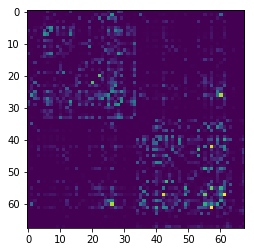

In [126]:
plt.imshow(Y[0]);

In [127]:
bin_Y = Y.copy()
bin_Y[Y > 0] = 1

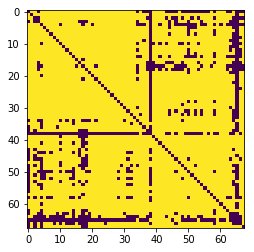

In [129]:
plt.imshow(bin_Y[0]);

In [132]:
SpecM = SpectraModel(theta=0.01, tol = 1e-3)
A = bin_Y[0]
B = SpecM.generate(A)

/home/ayagoz/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:390: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)


KeyboardInterrupt: 

In [133]:
np.linalg.norm(A - B)

35.327043465311391

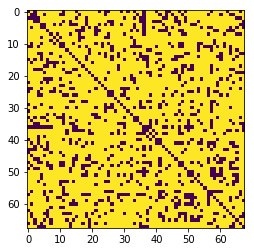

In [131]:
plt.imshow(B)

In [134]:
np.sum((A-B)**2)

1248.0

In [136]:
np.sum(abs(A-B))

1248.0

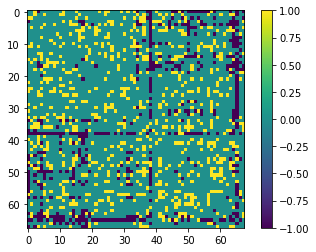

In [137]:
plt.imshow(A-B)
plt.colorbar();

In [138]:
s1, c1 = SpecM.density(A)
s2, c2 = SpecM.density(B)

/home/ayagoz/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:390: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)


/home/ayagoz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp_a_data = tmp_a.astype(float)
/home/ayagoz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:760: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = tmp_a.astype(np.intp)
/home/ayagoz/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:814: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/ayagoz/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:2037: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


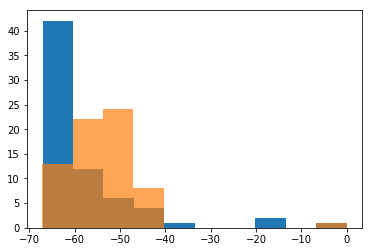

In [139]:
plt.hist(s1)
plt.hist(s2, alpha = 0.7);

In [109]:
G = nx.random_graphs.erdos_renyi_graph(5, 0.9)

In [110]:
a = np.array(nx.adjacency_matrix(G).todense())

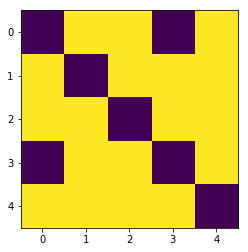

In [111]:
plt.imshow(a);

In [112]:
a

array([[0, 1, 1, 0, 1],
       [1, 0, 1, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 1, 1, 0, 1],
       [1, 1, 1, 1, 0]], dtype=int64)

In [113]:
spm = SpectraModel(theta = 0.044)
new_a = spm.generate(a)

4.85422761903e-15


/home/ayagoz/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:390: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)


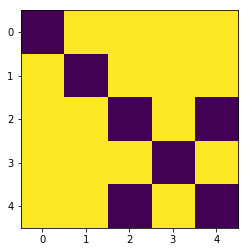

In [114]:
plt.imshow(new_a)

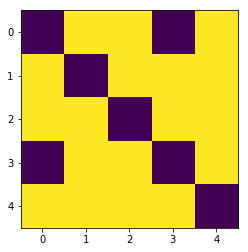

In [115]:
plt.imshow(a)

In [116]:
a.sum(axis = 0), new_a.sum(axis = 0)

(array([3, 4, 4, 3, 4], dtype=int64), array([4, 4, 3, 4, 3], dtype=int64))

In [117]:
new_spec, new_C = spm.density(new_a)
spec, C = spm.density(a)

/home/ayagoz/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:390: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)


/home/ayagoz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp_a_data = tmp_a.astype(float)
/home/ayagoz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:760: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = tmp_a.astype(np.intp)
/home/ayagoz/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:814: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/ayagoz/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:2037: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


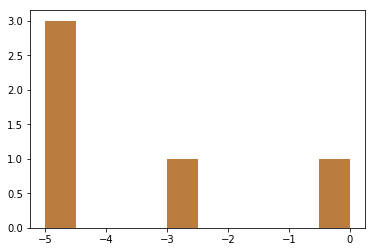

In [118]:
plt.hist(new_spec)
plt.hist(spec, alpha = 0.7);

In [ ]:

# path_tria= "/cobrain/groups/ml_group/data/HCP/HCP/"
path_new_tria = '/home/bgutman/datasets/HCP/Simplified_templates/'

name_simp = '_200_mean_IC5.m'
# name_orig = '_200_mean.m' 

# orig_coord, orig_tria = load_meshes_coor_tria(path_tria, name_orig)
new_coord , new_tria = load_meshes_coor_tria(path_new_tria, name_simp)


cv = ShuffleSplit(n_splits = 3, test_size=0.2)


path_res = '/home/ayagoz/connec/results/'
                   
Y = connec[:,0,:,:]
Y = np.array([squareform(one) for one in Y])
print(Y.shape)

m = int(len(new_coord)/2)
new_log_jac = np.concatenate([log_jac[:,0, :m], log_jac[:,1,:m]], axis = 1)

new_thick = np.concatenate([thinkness[:,0, :m], thinkness[:,1,:m]], axis = 1)

new_area = np.concatenate([mean_area_eq[0, :m] * np.exp(new_log_jac[:,:m]), 
                           mean_area_eq[1, :m] * np.exp(new_log_jac[:,m:])], axis = 1)

new_labels = np.concatenate([labels[0,:m], labels[1,:m]], axis = 0)

print('new ', new_log_jac.shape, new_thick.shape, new_area.shape, new_labels.shape)

X = np.concatenate([new_thick, new_log_jac, new_area], axis = 1)
X.shape, Y.shape